<a href="https://colab.research.google.com/github/Affiwhizz/Group1Project2/blob/main/Affiong.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# STEP 1: Importing Libraries

In [15]:
# For Data Handling and Preprocessing
import os
import numpy as np
import pandas as pd

# For Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# TensorFlow and Keras for deep learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import layers, models

# Scikit-learn for model evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# STEP 2: Data Setup and Loading

In [3]:
# Installing the Kaggle CLI tool to enable downloading datasets from kaggle
!pip install -q kaggle

In [2]:
# Uploading the Kaggle API token (kaggle.json) to authenticate and allow access to Kaggle datasets
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"affiongakpanisong","key":"bb217662b28f5eca9263073528a463a2"}'}

In [3]:
# Creating the Kaggle config folder, moving the API token into it, and setting file permissions
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
# Downloading the Animals-10 dataset using the Kaggle CLI
!kaggle datasets download -d alessiocorrado99/animals10

# Unzipping the downloaded dataset into a folder named 'animals10'
!unzip -q animals10.zip -d animals10

Dataset URL: https://www.kaggle.com/datasets/alessiocorrado99/animals10
License(s): GPL-2.0
animals10.zip: Skipping, found more recently modified local copy (use --force to force download)
replace animals10/raw-img/cane/OIF-e2bexWrojgtQnAPPcUfOWQ.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# STEP 3: Data Preprocessing

In [16]:
# Setting the path to the dataset
DATA_DIR = os.path.join(os.getcwd(), 'animals10/raw-img')

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Define preprocessing and augmentation layers
preprocessing_layers = Sequential([
    layers.Resizing(180, 180),            # Resize images to 180x180
    layers.Rescaling(1./255),             # Normalize pixel values to [0,1]
    layers.RandomFlip("horizontal"),      # Randomly flip images horizontally
    layers.RandomRotation(0.1),           # Randomly rotate images by 10%
    layers.RandomZoom(0.1),               # Randomly zoom images by 10%
    layers.RandomTranslation(0.1, 0.1)    # Randomly translate images
])

In [17]:
# Creating the image dataset with 80% training split
train_ds = image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(180, 180),
    batch_size=16
)

# Displaying the class names
class_names = train_ds.class_names
print("Class labels:", class_names)

# Creating the validation dataset with 20% validation split
val_ds = image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(180, 180),
    batch_size=16
)

Found 26179 files belonging to 10 classes.
Using 20944 files for training.
Class labels: ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']
Found 26179 files belonging to 10 classes.
Using 5235 files for validation.


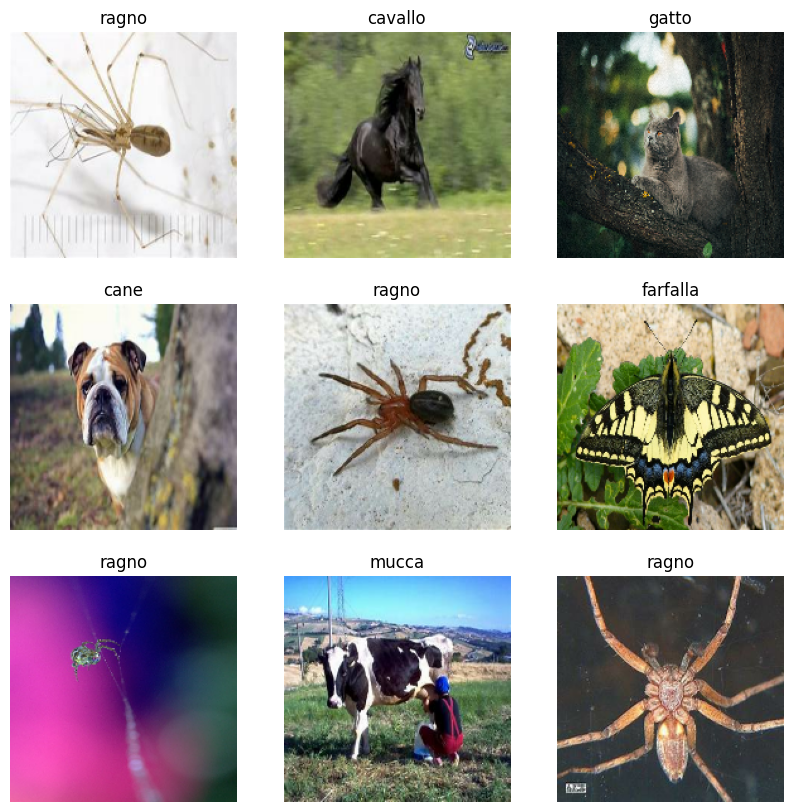

In [18]:
# Visualizing the dataset
plt.figure(figsize=(10, 10))

# Taking one batch from the training dataset
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")


In [19]:
# Normalizing the pixel values to be between 0 and 1
normalization_layer = tf.keras.layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

# Caching and prefetching the datasets for better performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

# STEP 4: Model Architecture (CNN)

In [20]:
# Building the model
model = models.Sequential([
    tf.keras.Input(shape=(180, 180, 3)),

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(10)
])

In [21]:
# Compiling the model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [13]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     6,553,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,648,266 (25.36 MB)

 Trainable params: 6,648,266 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

# STEP 5: Training

In [22]:
# Training the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 34s 23ms/step - accuracy: 0.3116 - loss: 1.9331 - val_accuracy: 0.5610 - val_loss: 1.2884
Epoch 2/10
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 38s 22ms/step - accuracy: 0.5673 - loss: 1.2656 - val_accuracy: 0.6157 - val_loss: 1.1500
Epoch 3/10
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 29s 22ms/step - accuracy: 0.6902 - loss: 0.9224 - val_accuracy: 0.6462 - val_loss: 1.1492
Epoch 4/10
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 31s 24ms/step - accuracy: 0.7956 - loss: 0.6150 - val_accuracy: 0.6237 - val_loss: 1.4340
Epoch 5/10
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 29s 22ms/step - accuracy: 0.8830 - loss: 0.3561 - val_accuracy: 0.6073 - val_loss: 1.8951
Epoch 6/10
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 35s 27ms/step - accuracy: 0.9363 - loss: 0.2095 - val_accuracy: 0.6029 - val_loss: 2.1914
Epoch 7/10
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 35s 22ms/step - accuracy: 0.9475 - loss: 0.1571 - val_accuracy: 0.6053 - val_loss: 2.4305
Epoch 8/10
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 29s 22ms/step - accuracy: 0.9635 -

# STEP 6: Model Evaluation

In [23]:
# Evaluating the model on a validation set
val_loss, val_accuracy = model.evaluate(val_ds)
print(f"Validation Accuracy: {val_accuracy:.4f}")

328/328 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.6012 - loss: 2.9357
Validation Accuracy: 0.6063


328/328 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step
📋 Classification Report:

              precision    recall  f1-score   support

        cane       0.18      0.15      0.16       947
     cavallo       0.08      0.08      0.08       522
    elefante       0.05      0.05      0.05       273
    farfalla       0.06      0.05      0.06       429
     gallina       0.12      0.15      0.14       593
       gatto       0.07      0.09      0.08       331
       mucca       0.07      0.06      0.06       399
      pecora       0.07      0.08      0.07       382
       ragno       0.22      0.21      0.22       979
  scoiattolo       0.05      0.04      0.04       380

    accuracy                           0.12      5235
   macro avg       0.10      0.10      0.10      5235
weighted avg       0.12      0.12      0.12      5235



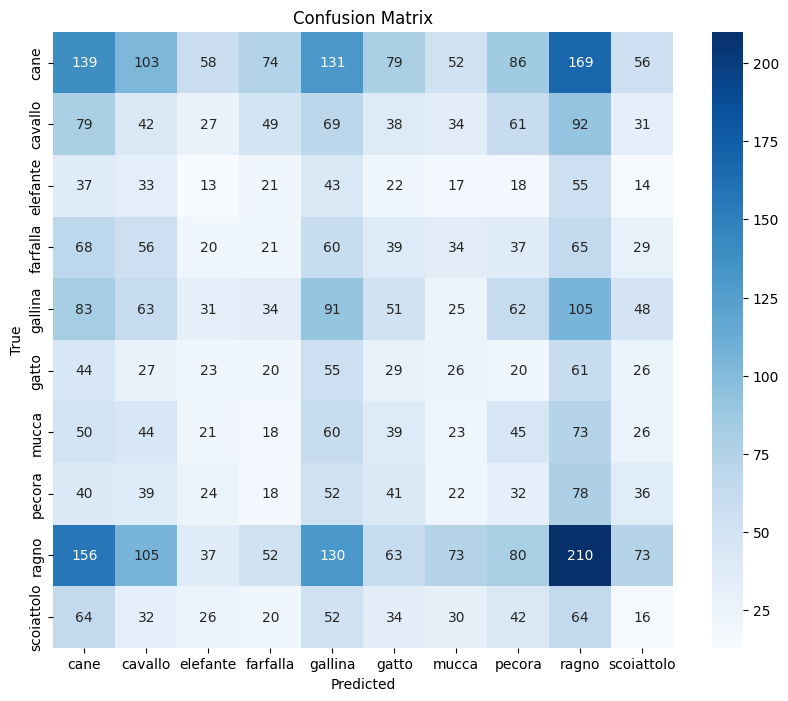

In [25]:
# Generating predictions
y_pred_probs = model.predict(val_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

# Extracting true labels
y_true = np.concatenate([y for x, y in val_ds], axis=0)

# Classification Report
from sklearn.metrics import classification_report
print("📋 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# displaying the confusion matrix to visualize model errors
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
